In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 5000
gamma=0.999999
#gamma=0.85
egreedy = 0.1
egreedy_final = 0.01
egreedy_decay = 500

report_interval=1000

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=50000

batch_size=32

update_target_frequency = 100

clip_error=False

In [9]:
env = gym.make('Breakout-ramDeterministic-v4')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/breakout_DQN',video_callable=lambda episode_id: episode_id%100==0,force=True)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
wgt=torch.ones(replay_memory_size,dtype=torch.float32).to(device)

In [14]:
%%time
idx=torch.multinomial(wgt,batch_size)

CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 2.29 ms


In [15]:
idx

tensor([15018,  2728, 32530, 45059, 46524,  8180, 22552, 35787, 23232, 43800,
        24464, 35876, 28608, 21180, 11842, 19710, 22402,  5147, 11506, 31323,
        36580, 25896,  7959,  7764, 33009, 26003, 30352,  9672, 22488, 19258,
        14059,  5543], device='cuda:4')

In [16]:
wgt.shape

torch.Size([50000])

In [17]:
class ExperienceReplay():
    def __init__(self, capacity, state_size, state_dtype, action_dtype):
        self.capacity=capacity
        self.memory_state=torch.zeros([capacity, state_size],dtype=state_dtype).to(device)
        self.memory_new_state=torch.zeros([capacity, state_size],dtype=state_dtype).to(device)
        self.memory_action=torch.zeros([capacity, 1],dtype=action_dtype).to(device)
        self.memory_reward=torch.zeros([capacity],dtype=torch.float32).to(device)
        self.memory_done=torch.zeros([capacity],dtype=torch.long).to(device)
        
        self.filled_to=0
        self.position=0
        
        self.state_dtype=state_dtype
        self.action_dtype=action_dtype
        
        #this is a dummy equal weights vector to do random samples
        self.wgt=torch.ones(capacity,dtype=torch.float32).to(device)
        
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            self.memory_state[self.position,:]=torch.tensor(state,dtype=self.state_dtype)
            self.memory_new_state[self.position,:]=torch.tensor(new_state,dtype=self.state_dtype)
            self.memory_action[self.position,0]=action
            self.memory_reward[self.position]=reward
            self.memory_done[self.position]=done
            
              
            self.position=(self.position+1)%self.capacity
            self.filled_to=min(self.capacity,self.filled_to+1)
        
    
    def sample(self,batch_size):
        
        idx=torch.multinomial(self.wgt,batch_size)
        #torch.randint(0,self.filled_to,(batch_size,),dtype=torch.long,device=device)
        return (self.memory_state[idx],
                self.memory_action[idx],
                self.memory_new_state[idx],
                self.memory_reward[idx],
                self.memory_done[idx])
        
    def __len__(self):
        return self.filled_to
    

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [19]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        for p in self.nn.parameters():
            print(p)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        action=env.action_space.sample()
        return action
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
        
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        #state=torch.Tensor(state).to(device)
        #state.requires_grad_(False)
        #new_state=torch.Tensor(new_state).to(device)
        #new_state.requires_grad_(False)
        #reward=torch.Tensor(reward).to(device)
        #reward.requires_grad_(False)
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        #action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #action.requires_grad_(False)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        #done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        #self.nn.eval()
        self.target_nn.eval()
        with torch.set_grad_enabled(False):    
            new_state_values=self.target_nn(new_state).detach()
            #print('shape of: new_state_values')
            #print(new_state_values.shape)
        
            max_new_state_values=torch.max(new_state_values,dim=1)[0]
            #print('shape of: max_new_state_values')
            #print(max_new_state_values.shape)
            target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
            #print('shape of: target_value')
            #print(target_value.shape)
            
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [20]:
env.observation_space.shape[0]

128

In [21]:
env.action_space.n

4

In [22]:
memory=ExperienceReplay(replay_memory_size,
                        env.observation_space.shape[0],
                        torch.float32,
                        torch.long)

In [23]:
qnet_agent=QNet_Agent()

Parameter containing:
tensor([[ 0.0271,  0.0017, -0.0872,  ..., -0.0401, -0.0049, -0.0484],
        [-0.0659,  0.0376,  0.0601,  ..., -0.0319, -0.0242, -0.0454],
        [ 0.0041, -0.0184, -0.0325,  ...,  0.0510,  0.0219, -0.0124],
        ...,
        [ 0.0520, -0.0518, -0.0135,  ..., -0.0455, -0.0001,  0.0712],
        [ 0.0429, -0.0015, -0.0524,  ...,  0.0127, -0.0466,  0.0117],
        [ 0.0472,  0.0472, -0.0585,  ..., -0.0517,  0.0163, -0.0068]],
       device='cuda:4', requires_grad=True)
Parameter containing:
tensor([-7.9178e-02, -8.2425e-02, -8.0187e-02,  6.5750e-02,  6.6049e-02,
         1.6305e-02, -2.1114e-02, -3.7307e-02, -7.7928e-02,  2.4560e-02,
        -8.6045e-02, -3.1636e-02,  6.6272e-03,  6.8194e-03, -4.5986e-02,
         8.7397e-02,  8.4012e-02,  3.0084e-02,  7.4705e-02,  1.4692e-03,
        -3.3653e-02, -1.3146e-02,  7.8831e-02,  6.0976e-02,  7.1231e-02,
        -4.0617e-02,  2.9206e-02, -7.2433e-02,  3.4168e-02,  7.7068e-02,
         5.5882e-02, -3.9530e-02, -6.209

In [24]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [25]:
%load_ext line_profiler

In [26]:

def train_agent():
    steps_total=np.full([num_episodes],-999,dtype=np.int32)
    reward_total=np.full([num_episodes],-999,dtype=np.int32)

    frames_total=0

    solved_after = 0
    solved = False


    start_time = time.time()

    for i_episode in range(num_episodes):
    
        state = env.reset()
        #for step in range(100):
        step=0
        reward_total[i_episode]=0
    
        while True:
        
            step+=1
            frames_total += 1

            epsilon=calculate_epsilon(frames_total)

            #action=env.action_space.sample()
            action=qnet_agent.select_action(state,epsilon)

            new_state, reward, done, info = env.step(action)
            memory.push(state, action, new_state,
                        reward, done)

            reward_total[i_episode]+=reward

            qnet_agent.optimize()

            state=new_state
        
        
            if done:
                steps_total[i_episode]=step

                if i_episode>100:
                    mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100

                    if (mean_reward_100 > score_to_solve and solved == False):
                        print("SOLVED! After %i episodes " % i_episode)
                        solved_after = i_episode
                        solved = True

                if (i_episode % report_interval == 0 and i_episode>1):
                    print("**** Episode  {} **** ".format(i_episode))
                    recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
                    print("Recent average reward: {}".format(recent_avg_reward))
                    if i_episode>100:
                        print("Reward over last 100: {}".format(mean_reward_100))
                    full_avg_so_far=np.average(reward_total[:i_episode])
                    print("Average over all episodes so far: {}".format(full_avg_so_far))
                    print("epsilon: {}".format(epsilon))

                    #print("Episode {} finished after: {}".format(i_episode,step))
                break

    if solved:
        print("Solved after %i episodes" % solved_after)
        

In [27]:
### %lprun -f train_agent train_agent()

In [28]:
%lprun -f ExperienceReplay.sample -f ExperienceReplay.push -f QNet_Agent.optimize -f train_agent train_agent()

**** Episode  1000 **** 
Recent average reward: 1.121
Reward over last 100: 1.06
Average over all episodes so far: 1.121
epsilon: 0.01
**** Episode  2000 **** 
Recent average reward: 1.092
Reward over last 100: 1.21
Average over all episodes so far: 1.1065
epsilon: 0.01
**** Episode  3000 **** 
Recent average reward: 1.029
Reward over last 100: 1.05
Average over all episodes so far: 1.0806666666666667
epsilon: 0.01
**** Episode  4000 **** 
Recent average reward: 1.102
Reward over last 100: 1.06
Average over all episodes so far: 1.086
epsilon: 0.01


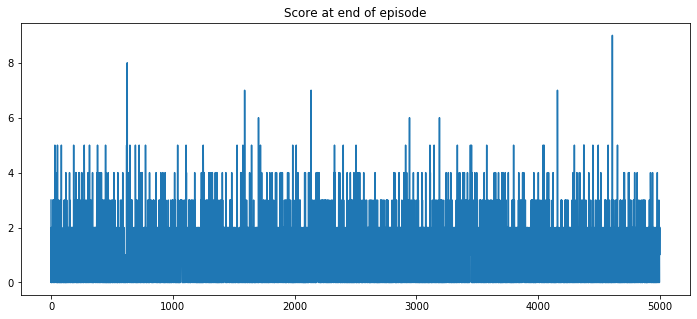

In [23]:
plt.figure(2,figsize=[12,5])
plt.title("Score at end of episode")
plt.plot(reward_total[:frames_total])
plt.show()

In [24]:
i_episode

4999

In [25]:
print("Average number of steps: {}". format(np.average(steps_total[:num_episodes])))

Average number of steps: 176.509


In [26]:
print("Average number of steps: {}". format(np.average(steps_total)))
print("Average reward in last 100 episodes: {}". format(np.average(reward_total[num_episodes-100:num_episodes])))



Average number of steps: 176.509
Average reward in last 100 episodes: 1.04


In [27]:
frames_total

882545

for just running the env; no mp4; 50000 episodes:  
CPU times: user 1h 28min 6s, sys: 19.4 s, total: 1h 28min 26s
Wall time: 1h 28min 8s  
Average number of steps: 177.34648
Average reward in last 100 episodes: 1.13

for also storing action 5000 episodes
CPU times: user 8min 56s, sys: 3.69 s, total: 9min
Wall time: 8min 58s
- this is adding oly 10s over 5k episodes dedicated to filling the memory

for also selecting an action using nn (starting eps=0.1) (5k episodes): 
CPU times: user 10min 19s, sys: 3.1 s, total: 10min 22s
Wall time: 10min 21s

for also sampling the memory:
CPU times: user 10min 51s, sys: 1.97 s, total: 10min 53s
Wall time: 10min 52s

for full thing (5000 episodes)
CPU times: user 1h 19min 2s, sys: 20min 18s, total: 1h 39min 20s
Wall time: 1h 39min 12s



5000 episodes full thing line profiling:

Timer unit: 1e-06 s

Total time: 4073.5 s
File: <ipython-input-15-0f42c0df46c8>
Function: optimize at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    30                                               def optimize(self):
    31                                                   
    32    887138    3359323.0      3.8      0.1          if len(memory)<batch_size:
    33                                                       return
    34                                                   
    35    887138  207028244.0    233.4      5.1          state, action, new_state, reward, done = memory.sample(batch_size)
    36                                                   
    37    887138  716564489.0    807.7     17.6          state=torch.Tensor(state).to(device)
    38    887138  682248656.0    769.0     16.7          new_state=torch.Tensor(new_state).to(device)
    39    887138   29214742.0     32.9      0.7          reward=torch.Tensor(reward).to(device)
    40                                                   
    41                                                   #the view call below is to transform into column vector
    42                                                   #so that it can be used in the gather call
    43                                                   #i.e. we will use it to pick out from the computed value
                                                                                    
    44                                                   #tensor only values indexed by selected action
    45    887138   52334732.0     59.0      1.3          action=(torch.Tensor(action).view(-1,1).long()).to(device)
    46                                                   #print('action: ')
    47                                                   #print(action)
    48                                                   #print('contiguous?', action.is_contiguous())
    49    887138   27262792.0     30.7      0.7          done=torch.Tensor(done).to(device)
    50                                                   
    51                                                   #print('shape of: state, new state, reward, action, done:')
    52                                                   #print(state.shape)
    53                                                   #print(new_state.shape)
    54                                                   #print(reward.shape)
    55                                                   #print(action.shape)
    56                                                   #print(done.shape)
    57                                                   
    58                                                   
    59    887138   68419159.0     77.1      1.7          self.nn.eval()
    60    887138   48190975.0     54.3      1.2          self.target_nn.eval()
    61                                                       
    62    887138  218498245.0    246.3      5.4          new_state_values=self.target_nn(new_state).detach()
    63                                                   #print('shape of: new_state_values')
    64                                                   #print(new_state_values.shape)
    65                                                   
    66    887138   31577595.0     35.6      0.8          max_new_state_values=torch.max(new_state_values,dim=1)[0]
    67                                                   #print('shape of: max_new_state_values')
    68                                                   #print(max_new_state_values.shape)
    69    887138  115804397.0    130.5      2.8          target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
    70                                                   
    71                                                   #print('shape of: target_value')
    72                                                   #print(target_value.shape)
    73    887138   58834761.0     66.3      1.4          self.nn.train()
    74                                                   
    75                                                   #this will select only the values of the desired actions
    76    887138  205661260.0    231.8      5.0          predicted_value=torch.gather(self.nn(state),1,action)
    77                                                   #print('shape of: predicted_value')
    78                                                   #print(predicted_value.shape)
    79                                                   
    80                                                   
    81    887138   73987605.0     83.4      1.8          loss=self.loss_function(predicted_value,target_value)
    82    887138   58915118.0     66.4      1.4          self.optimizer.zero_grad()
    83    887138  772975201.0    871.3     19.0          loss.backward()
    84                                                   
    85    887138    2187213.0      2.5      0.1          if clip_error:
    86                                                       for param in self.nn.parameters():
    87                                                           param.grad.clamp_(-1.0,1.0)
    88                                                   
    89    887138  693066454.0    781.2     17.0          self.optimizer.step()
    90                                                   
    91    887138    2710617.0      3.1      0.1          if self.update_target_counter % update_target_frequency == 0:
    92                                                       #print("***********************")
    93                                                       #print("UPDATING TARGET NETWORK")
    94                                                       #print("update counter: {}".format(self.update_target_counter))
    95                                                       #print("***********************")
    96      8871    2748086.0    309.8      0.1              self.target_nn.load_state_dict(self.nn.state_dict())
    97                                                   
    98    887138    1911335.0      2.2      0.0          self.update_target_counter+=1

Total time: 5181.55 s
File: <ipython-input-23-8f49ffd4dfdc>
    
    
    
# randint sampling:
Timer unit: 1e-06 s

Total time: 290.136 s
File: <ipython-input-17-576c7d09f2f1>
Function: push at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    21                                               def push(self, state,
    22                                                        action, new_state,
    23                                                        reward, done):
    24                                                   
    25    889834  100576649.0    113.0     34.7              self.memory_state[self.position,:]=torch.tensor(state,dtype=self.state_dtype)
    26    889834   49530240.0     55.7     17.1              self.memory_new_state[self.position,:]=torch.tensor(new_state,dtype=self.state_dtype)
    27    889834   59512593.0     66.9     20.5              self.memory_action[self.position,0]=action
    28    889834   39710386.0     44.6     13.7              self.memory_reward[self.position]=reward
    29    889834   34742775.0     39.0     12.0              self.memory_done[self.position]=done
    30                                                       
    31                                                         
    32    889834    2464796.0      2.8      0.8              self.position=(self.position+1)%self.capacity
    33    889834    3598973.0      4.0      1.2              self.filled_to=min(self.capacity,self.filled_to+1)

Total time: 168.544 s
File: <ipython-input-17-576c7d09f2f1>
Function: sample at line 36

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    36                                               def sample(self,batch_size):
    37                                                   
    38                                                   #idx=torch.multinomial(self.wgt,batch_size)
    39    889803   31660965.0     35.6     18.8          torch.randint(0,self.filled_to,(batch_size,),dtype=torch.long,device=device)
    40    889803   42294848.0     47.5     25.1          return (self.memory_state[idx],
    41    889803   25687324.0     28.9     15.2                  self.memory_action[idx],
    42    889803   23916755.0     26.9     14.2                  self.memory_new_state[idx],
    43    889803   23182104.0     26.1     13.8                  self.memory_reward[idx],
    44    889803   21801538.0     24.5     12.9                  self.memory_done[idx])

Total time: 2800.33 s
File: <ipython-input-19-a79d60f1377a>
Function: optimize at line 32

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    32                                               def optimize(self):
    33                                                   
    34    889834    4353881.0      4.9      0.2          if len(memory)<batch_size:
    35        31         37.0      1.2      0.0              return
    36                                                   
    37    889803  177345080.0    199.3      6.3          state, action, new_state, reward, done = memory.sample(batch_size)
    38                                                   
    39                                                   #state=torch.Tensor(state).to(device)
    40                                                   #state.requires_grad_(False)
    41                                                   #new_state=torch.Tensor(new_state).to(device)
    42                                                   #new_state.requires_grad_(False)
    43                                                   #reward=torch.Tensor(reward).to(device)
    44                                                   #reward.requires_grad_(False)
    45                                                   #the view call below is to transform into column vector
    46                                                   #so that it can be used in the gather call
    47                                                   #i.e. we will use it to pick out from the computed value
    48                                                   #tensor only values indexed by selected action
    49                                                   #action=(torch.Tensor(action).view(-1,1).long()).to(device)
    50                                                   #action.requires_grad_(False)
    51                                                   #print('action: ')
    52                                                   #print(action)
    53                                                   #print('contiguous?', action.is_contiguous())
    54                                                   #done=torch.Tensor(done).to(device)
    55                                                   
    56                                                   #print('shape of: state, new state, reward, action, done:')
    57                                                   #print(state.shape)
    58                                                   #print(new_state.shape)
    59                                                   #print(reward.shape)
    60                                                   #print(action.shape)
    61                                                   #print(done.shape)
    62                                                   
    63                                                   
    64                                                   #self.nn.eval()
    65    889803   74046917.0     83.2      2.6          self.target_nn.eval()
    66    889803    7552511.0      8.5      0.3          with torch.set_grad_enabled(False):    
    67    889803  207276703.0    232.9      7.4              new_state_values=self.target_nn(new_state).detach()
    68                                                       #print('shape of: new_state_values')
    69                                                       #print(new_state_values.shape)
    70                                                   
    71    889803   34352347.0     38.6      1.2              max_new_state_values=torch.max(new_state_values,dim=1)[0]
    72                                                       #print('shape of: max_new_state_values')
    73                                                       #print(max_new_state_values.shape)
    74    889803  133380589.0    149.9      4.8              target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
    75                                                   
    76                                                       #print('shape of: target_value')
    77                                                       #print(target_value.shape)
    78                                                       
    79    889803   62277301.0     70.0      2.2          self.nn.train()
    80                                                   
    81                                                   #this will select only the values of the desired actions
    82    889803  230407230.0    258.9      8.2          predicted_value=torch.gather(self.nn(state),1,action)
    83                                                   #print('shape of: predicted_value')
    84                                                   #print(predicted_value.shape)
    85                                                   
    86                                                   
    87    889803   83103230.0     93.4      3.0          loss=self.loss_function(predicted_value,target_value)
    88    889803   64160181.0     72.1      2.3          self.optimizer.zero_grad()
    89    889803  897196716.0   1008.3     32.0          loss.backward()
    90                                                   
    91    889803    4140335.0      4.7      0.1          if clip_error:
    92                                                       for param in self.nn.parameters():
    93                                                           param.grad.clamp_(-1.0,1.0)
    94                                                   
    95    889803  812652828.0    913.3     29.0          self.optimizer.step()
    96                                                   
    97    889803    3199095.0      3.6      0.1          if self.update_target_counter % update_target_frequency == 0:
    98                                                       #print("***********************")
    99                                                       #print("UPDATING TARGET NETWORK")
   100                                                       #print("update counter: {}".format(self.update_target_counter))
   101                                                       #print("***********************")
   102      8899    2806076.0    315.3      0.1              self.target_nn.load_state_dict(self.nn.state_dict())
   103                                                   
   104    889803    2075509.0      2.3      0.1          self.update_target_counter+=1

Total time: 4264.18 s
File: <ipython-input-26-8f49ffd4dfdc>
Function: train_agent at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def train_agent():
     2         1        265.0    265.0      0.0      steps_total=np.full([num_episodes],-999,dtype=np.int32)
     3         1         45.0     45.0      0.0      reward_total=np.full([num_episodes],-999,dtype=np.int32)
     4                                           
     5         1          2.0      2.0      0.0      frames_total=0
     6                                           
     7         1          2.0      2.0      0.0      solved_after = 0
     8         1          3.0      3.0      0.0      solved = False
     9                                           
    10                                           
    11         1          6.0      6.0      0.0      start_time = time.time()
    12                                           
    13      5001       7202.0      1.4      0.0      for i_episode in range(num_episodes):
    14                                               
    15      5000   75816573.0  15163.3      1.8          state = env.reset()
    16                                                   #for step in range(100):
    17      5000       8991.0      1.8      0.0          step=0
    18      5000      11946.0      2.4      0.0          reward_total[i_episode]=0
    19                                               
    20      5000       6022.0      1.2      0.0          while True:
    21                                                   
    22    889834    1192687.0      1.3      0.0              step+=1
    23    889834    1228575.0      1.4      0.0              frames_total += 1
    24                                           
    25    889834    6235778.0      7.0      0.1              epsilon=calculate_epsilon(frames_total)
    26                                           
    27                                                       #action=env.action_space.sample()
    28    889834   59035586.0     66.3      1.4              action=qnet_agent.select_action(state,epsilon)
    29                                           
    30    889834  935042763.0   1050.8     21.9              new_state, reward, done, info = env.step(action)
    31    889834    2106425.0      2.4      0.0              memory.push(state, action, new_state,
    32    889834  300053356.0    337.2      7.0                          reward, done)
    33                                           
    34    889834   23111585.0     26.0      0.5              reward_total[i_episode]+=reward
    35                                           
    36    889834 2855919520.0   3209.5     67.0              qnet_agent.optimize()
    37                                           
    38    889834    2925834.0      3.3      0.1              state=new_state
    39                                                   
    40                                                   
    41    889834    1153529.0      1.3      0.0              if done:
    42      5000      17092.0      3.4      0.0                  steps_total[i_episode]=step
    43                                           
    44      5000       7474.0      1.5      0.0                  if i_episode>100:
    45      4899     254565.0     52.0      0.0                      mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
    46                                           
    47      4899      17653.0      3.6      0.0                      if (mean_reward_100 > score_to_solve and solved == False):
    48                                                                   print("SOLVED! After %i episodes " % i_episode)
    49                                                                   solved_after = i_episode
    50                                                                   solved = True
    51                                           
    52      5000       8114.0      1.6      0.0                  if (i_episode % report_interval == 0 and i_episode>1):
    53         4       2294.0    573.5      0.0                      print("**** Episode  {} **** ".format(i_episode))
    54         4       3260.0    815.0      0.0                      recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
    55         4        373.0     93.2      0.0                      print("Recent average reward: {}".format(recent_avg_reward))
    56         4          8.0      2.0      0.0                      if i_episode>100:
    57         4        224.0     56.0      0.0                          print("Reward over last 100: {}".format(mean_reward_100))
    58         4        297.0     74.2      0.0                      full_avg_so_far=np.average(reward_total[:i_episode])
    59         4        220.0     55.0      0.0                      print("Average over all episodes so far: {}".format(full_avg_so_far))
    60         4        200.0     50.0      0.0                      print("epsilon: {}".format(epsilon))
    61                                           
    62                                                               #print("Episode {} finished after: {}".format(i_episode,step))
    63      5000       6665.0      1.3      0.0                  break
    64                                           
    65         1          1.0      1.0      0.0      if solved:
    66                                                   print("Solved after %i episodes" % solved_after)
    
    
    
    
    
# multinomial sampling (no max (so buggy)):
Timer unit: 1e-06 s

Total time: 34357.5 s
File: <ipython-input-17-f863b8eb5576>
Function: push at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    21                                               def push(self, state,
    22                                                        action, new_state,
    23                                                        reward, done):
    24                                                   
    25    887359 34169597747.0  38507.1     99.5              self.memory_state[self.position,:]=torch.tensor(state,dtype=self.state_dtype)
    26    887359   55937921.0     63.0      0.2              self.memory_new_state[self.position,:]=torch.tensor(new_state,dtype=self.state_dtype)
    27    887359   56721573.0     63.9      0.2              self.memory_action[self.position,0]=action
    28    887359   36595475.0     41.2      0.1              self.memory_reward[self.position]=reward
    29    887359   32991397.0     37.2      0.1              self.memory_done[self.position]=done
    30                                                       
    31                                                         
    32    887359    2572369.0      2.9      0.0              self.position=(self.position+1)%self.capacity
    33    887359    3071084.0      3.5      0.0              self.filled_to=min(self.capacity,self.filled_to+1)

Total time: 934.219 s
File: <ipython-input-17-f863b8eb5576>
Function: sample at line 36

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    36                                               def sample(self,batch_size):
    37                                                   
    38    887328  807357421.0    909.9     86.4          idx=torch.multinomial(self.wgt,batch_size)
    39                                                   #torch.randint(0,self.filled_to,(batch_size,),dtype=torch.long,device=device)
    40    887328   38666057.0     43.6      4.1          return (self.memory_state[idx],
    41    887328   24283301.0     27.4      2.6                  self.memory_action[idx],
    42    887328   21810904.0     24.6      2.3                  self.memory_new_state[idx],
    43    887328   20950187.0     23.6      2.2                  self.memory_reward[idx],
    44    887328   21151460.0     23.8      2.3                  self.memory_done[idx])

Total time: 3696.76 s
File: <ipython-input-19-a79d60f1377a>
Function: optimize at line 32

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    32                                               def optimize(self):
    33                                                   
    34    887359    4060660.0      4.6      0.1          if len(memory)<batch_size:
    35        31         38.0      1.2      0.0              return
    36                                                   
    37    887328  943524281.0   1063.3     25.5          state, action, new_state, reward, done = memory.sample(batch_size)
    38                                                   
    39                                                   #state=torch.Tensor(state).to(device)
    40                                                   #state.requires_grad_(False)
    41                                                   #new_state=torch.Tensor(new_state).to(device)
    42                                                   #new_state.requires_grad_(False)
    43                                                   #reward=torch.Tensor(reward).to(device)
    44                                                   #reward.requires_grad_(False)
    45                                                   #the view call below is to transform into column vector
    46                                                   #so that it can be used in the gather call
    47                                                   #i.e. we will use it to pick out from the computed value
    48                                                   #tensor only values indexed by selected action
    49                                                   #action=(torch.Tensor(action).view(-1,1).long()).to(device)
    50                                                   #action.requires_grad_(False)
    51                                                   #print('action: ')
    52                                                   #print(action)
    53                                                   #print('contiguous?', action.is_contiguous())
    54                                                   #done=torch.Tensor(done).to(device)
    55                                                   
    56                                                   #print('shape of: state, new state, reward, action, done:')
    57                                                   #print(state.shape)
    58                                                   #print(new_state.shape)
    59                                                   #print(reward.shape)
    60                                                   #print(action.shape)
    61                                                   #print(done.shape)
    62                                                   
    63                                                   
    64                                                   #self.nn.eval()
    65    887328   69361203.0     78.2      1.9          self.target_nn.eval()
    66    887328    7032881.0      7.9      0.2          with torch.set_grad_enabled(False):    
    67    887328  193245243.0    217.8      5.2              new_state_values=self.target_nn(new_state).detach()
    68                                                       #print('shape of: new_state_values')
    69                                                       #print(new_state_values.shape)
    70                                                   
    71    887328   31701066.0     35.7      0.9              max_new_state_values=torch.max(new_state_values,dim=1)[0]
    72                                                       #print('shape of: max_new_state_values')
    73                                                       #print(max_new_state_values.shape)
    74    887328  126365153.0    142.4      3.4              target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
    75                                                   
    76                                                       #print('shape of: target_value')
    77                                                       #print(target_value.shape)
    78                                                       
    79    887328   56871773.0     64.1      1.5          self.nn.train()
    80                                                   
    81                                                   #this will select only the values of the desired actions
    82    887328  218686302.0    246.5      5.9          predicted_value=torch.gather(self.nn(state),1,action)
    83                                                   #print('shape of: predicted_value')
    84                                                   #print(predicted_value.shape)
    85                                                   
    86                                                   
    87    887328   78276841.0     88.2      2.1          loss=self.loss_function(predicted_value,target_value)
    88    887328   60699406.0     68.4      1.6          self.optimizer.zero_grad()
    89    887328 1053556559.0   1187.3     28.5          loss.backward()
    90                                                   
    91    887328    5040711.0      5.7      0.1          if clip_error:
    92                                                       for param in self.nn.parameters():
    93                                                           param.grad.clamp_(-1.0,1.0)
    94                                                   
    95    887328  840738764.0    947.5     22.7          self.optimizer.step()
    96                                                   
    97    887328    3024155.0      3.4      0.1          if self.update_target_counter % update_target_frequency == 0:
    98                                                       #print("***********************")
    99                                                       #print("UPDATING TARGET NETWORK")
   100                                                       #print("update counter: {}".format(self.update_target_counter))
   101                                                       #print("***********************")
   102      8874    2691358.0    303.3      0.1              self.target_nn.load_state_dict(self.nn.state_dict())
   103                                                   
   104    887328    1880786.0      2.1      0.1          self.update_target_counter+=1

Total time: 39111.1 s
File: <ipython-input-26-8f49ffd4dfdc>
Function: train_agent at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def train_agent():
     2         1         90.0     90.0      0.0      steps_total=np.full([num_episodes],-999,dtype=np.int32)
     3         1         30.0     30.0      0.0      reward_total=np.full([num_episodes],-999,dtype=np.int32)
     4                                           
     5         1          3.0      3.0      0.0      frames_total=0
     6                                           
     7         1          2.0      2.0      0.0      solved_after = 0
     8         1          2.0      2.0      0.0      solved = False
     9                                           
    10                                           
    11         1          3.0      3.0      0.0      start_time = time.time()
    12                                           
    13      5001       7728.0      1.5      0.0      for i_episode in range(num_episodes):
    14                                               
    15      5000   70174953.0  14035.0      0.2          state = env.reset()
    16                                                   #for step in range(100):
    17      5000       9194.0      1.8      0.0          step=0
    18      5000      12349.0      2.5      0.0          reward_total[i_episode]=0
    19                                               
    20      5000       6021.0      1.2      0.0          while True:
    21                                                   
    22    887359    1117140.0      1.3      0.0              step+=1
    23    887359    1136657.0      1.3      0.0              frames_total += 1
    24                                           
    25    887359    5759222.0      6.5      0.0              epsilon=calculate_epsilon(frames_total)
    26                                           
    27                                                       #action=env.action_space.sample()
    28    887359   52579224.0     59.3      0.1              action=qnet_agent.select_action(state,epsilon)
    29                                           
    30    887359  826258821.0    931.1      2.1              new_state, reward, done, info = env.step(action)
    31    887359    1912579.0      2.2      0.0              memory.push(state, action, new_state,
    32    887359 34367077552.0  38729.6     87.9                          reward, done)
    33                                           
    34    887359   21998137.0     24.8      0.1              reward_total[i_episode]+=reward
    35                                           
    36    887359 3758990705.0   4236.2      9.6              qnet_agent.optimize()
    37                                           
    38    887359    2534957.0      2.9      0.0              state=new_state
    39                                                   
    40                                                   
    41    887359    1101282.0      1.2      0.0              if done:
    42      5000      25283.0      5.1      0.0                  steps_total[i_episode]=step
    43                                           
    44      5000       7108.0      1.4      0.0                  if i_episode>100:
    45      4899     347613.0     71.0      0.0                      mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
    46                                           
    47      4899      17965.0      3.7      0.0                      if (mean_reward_100 > score_to_solve and solved == False):
    48                                                                   print("SOLVED! After %i episodes " % i_episode)
    49                                                                   solved_after = i_episode
    50                                                                   solved = True
    51                                           
    52      5000       7881.0      1.6      0.0                  if (i_episode % report_interval == 0 and i_episode>1):
    53         4       2176.0    544.0      0.0                      print("**** Episode  {} **** ".format(i_episode))
    54         4       1841.0    460.2      0.0                      recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
    55         4        289.0     72.2      0.0                      print("Recent average reward: {}".format(recent_avg_reward))
    56         4          8.0      2.0      0.0                      if i_episode>100:
    57         4        189.0     47.2      0.0                          print("Reward over last 100: {}".format(mean_reward_100))
    58         4        262.0     65.5      0.0                      full_avg_so_far=np.average(reward_total[:i_episode])
    59         4        199.0     49.8      0.0                      print("Average over all episodes so far: {}".format(full_avg_so_far))
    60         4        186.0     46.5      0.0                      print("epsilon: {}".format(epsilon))
    61                                           
    62                                                               #print("Episode {} finished after: {}".format(i_episode,step))
    63      5000       6117.0      1.2      0.0                  break
    64                                           
    65         1          1.0      1.0      0.0      if solved:
    66                                                   print("Solved after %i episodes" % solved_after)

plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

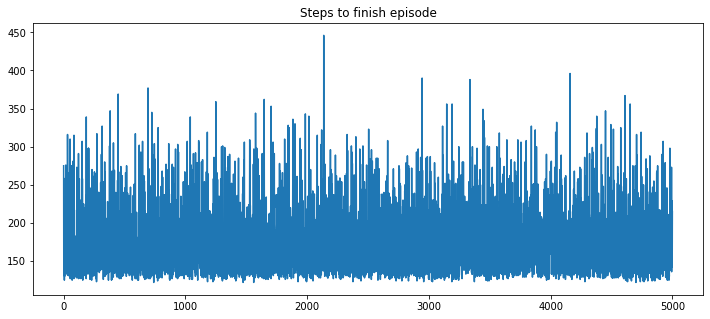

In [28]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total[:frames_total])
plt.show()